beginning

In [14]:
import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
# import seaborn as sns

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import forceatlas2_layout, circular_layout
from datashader.bundling import connect_edges, hammer_bundle

import networkx as nx
from networkx.algorithms import bipartite


In [15]:

#import instance

XY = np.load('./weibo/dense_instance.npz')['arr_0']
Y = XY[:,:,-3]
X = XY[:,:,:-3]

def export_graph_instance(Y, title):
    g = nx.DiGraph()
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if Y[i,j] > 0:
                g.add_edge(str(i),str(j+500),weight=Y[i,j])
    nx.write_gml(g,title)

print(Y.shape)
# export_graph_instance(Y, 'graph_viz/instance.gml')

(500, 500)


In [16]:
# definition of g_instance

U = list(range(Y.shape[0]))
V = list(range(Y.shape[0], Y.shape[0] + Y.shape[1]))
g_instance = nx.DiGraph()
g_instance.add_nodes_from(U, bipartite=0)
g_instance.add_nodes_from(V, bipartite=1)
for u in range(Y.shape[0]) : 
    for vx in range(Y.shape[1]) : 
        if Y[u,vx] > 0 :
            g_instance.add_edge(u, V[vx]) #, weight = Y[u,vx])

#adding features
featuresU = ['#followers', '#friends','#activities','verified','gender','#cascades','#likes','#reposts','degree','PageRank','high-spread topic','med-spread topic','low-spread topic' ]
featuresV = ['#followers', '#friends','#activities','verified','gender','degree','PageRank','high-spread topic','med-spread topic','low-spread topic' ]

for u in range(0,500) :
    for i, feature in enumerate(featuresU) : 
        g_instance.nodes[u][feature] = X[u,0,i]
for v in range(500,1000) :
    for i, feature in enumerate(featuresV) : 
        g_instance.nodes[v][feature] = X[0,v-500,i + len(featuresU)]
        
        

In [48]:
#computing layouts

#bipartite layout
pos_bipartite = nx.bipartite_layout(g_instance, U)

#forceatlas2 layout
pos_force = nx.spring_layout(g_instance)

#cross edge reduction layout
import igraph 
g_instance_igraph = igraph.Graph.Bipartite([0] * 500 + [1] * 500,g_instance.edges())
g_instance_igraph.simplify()

pos_cer = g_instance_igraph.layout_bipartite(hgap = 1, vgap = 1, maxiter = 1000)
pos_cer = pd.DataFrame(pos_cer.coords, columns=['x', 'y'])
pos_cer.index.name = 'id'
pos_cer = dict({i : np.array([pos_cer.loc[i, 'x'], pos_cer.loc[i, 'y']]) for i in range(pos_cer.shape[0])})

del(g_instance_igraph)

def circular_bi(pos, r1, r2) : 
    """projects bipartite layout where u on top and v on bottom to two circles with different radius""" 
    pos_circ = {}
    xmin = min([pos[k][0] for k in pos.keys()])
    xmax = max([pos[k][0] for k in pos.keys()])
    ymin = min([pos[k][1] for k in pos.keys()])
    ymax = max([pos[k][1] for k in pos.keys()])
    for k in pos.keys() :
        r = r1 if pos[k][1] == ymin else r2
        pos_circ[k] = np.array([r * np.cos(2*np.pi * (xmax - pos[k][0]) / (xmax - xmin)), r * np.sin( 2 * np.pi * (xmax - pos[k][0]) / (xmax - xmin))])
    return pos_circ

pos_cer_circ = circular_bi(pos_cer, 2.0,1.0)

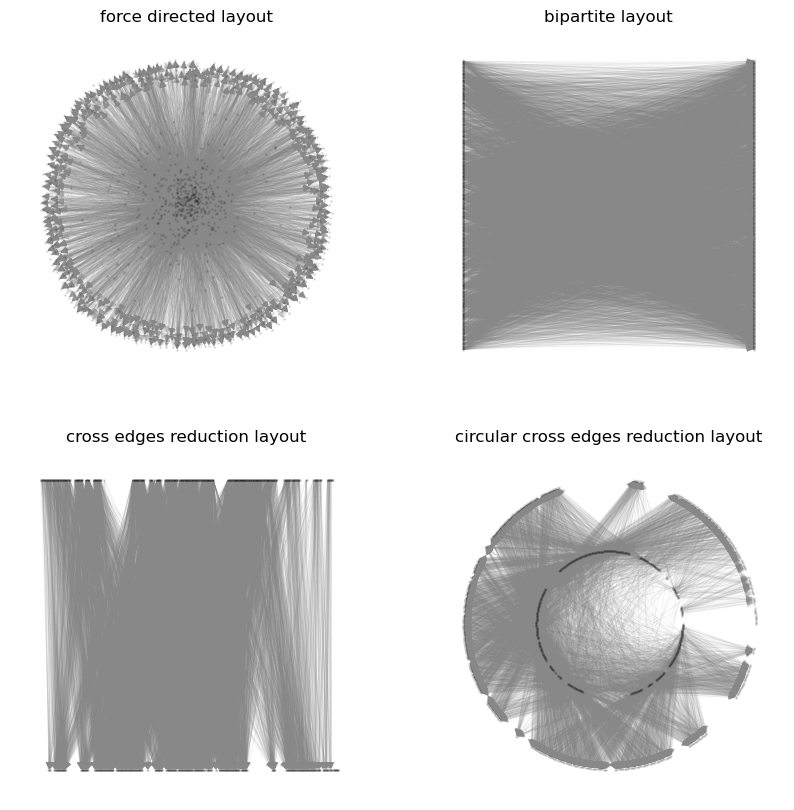

In [24]:

fig, ax = plt.subplots(2,2,figsize=(10,10))
nx.draw(g_instance, pos=pos_force, ax=ax[0,0], 
        node_size=1, node_color='black',
        edge_color='#888888', width=0.5, alpha = 0.1, )
nx.draw(g_instance, pos=pos_bipartite, ax=ax[0,1], 
        node_size=1, node_color='black', 
        edge_color='#888888', width=0.5, alpha = 0.1,  )
nx.draw(g_instance, pos=pos_cer, ax = ax[1,0], 
        node_size=1, node_color='black', 
        edge_color='#888888', width=0.5, alpha = 0.1, )
nx.draw(g_instance, pos=pos_cer_circ, ax=ax[1,1],
        node_size=1, node_color = 'black', 
        edge_color='#888888', width=0.5, alpha = 0.1)
ax[0,0].set_title("force directed layout")
ax[0,1].set_title("bipartite layout")
ax[1,0].set_title("cross edges reduction layout")
ax[1,1].set_title("circular cross edges reduction layout")
plt.show()


def pos_nx_to_ds(pos) : 
    data = [[node]+pos[node].tolist() for node in pos.keys()]
    nodes = pd.DataFrame(data, columns=['id', 'x', 'y'])
    nodes.set_index('id', inplace=True)
    return nodes

def get_bundle_curves(g, pos, bundling_args={}) : 
    nodes = pos_nx_to_ds(pos)
    edges = pd.DataFrame(list(g.edges), columns=['source', 'target'])
    edges = hammer_bundle(nodes, edges, **bundling_args)
    return edges

def print_bundling(g, pos, bundling_args={}) : 
    nodes = pos_nx_to_ds(pos)
    edges = get_bundle_curves(g, pos, bundling_args=bundling_args)

    cvsopts = dict(plot_height=500, plot_width=500)
    canvas = ds.Canvas(x_range= (nodes.x.min(), nodes.x.max()), y_range=(nodes.y.min(), nodes.y.max()), **cvsopts)
    agg=canvas.points(nodes,'x','y')
    nodes_img = tf.shade(agg)
    edges_img = tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name="")
    stack = tf.stack(edges_img, nodes_img, how="over",)
    return tf.Images(stack)

bundling_args_force = {'initial_bandwidth' : 0.05, 
                'decay' : 1.0, 
                'iterations' : 5, 
                'tension' : 1.5, 
                'batch_size' : 5000,
                'advect_iterations' : 50}

bundling_args_bipartite = {'initial_bandwidth' : 0.1, 
                'decay' : 0.8, 
                'iterations' : 10, 
                'tension' : 1.8, 
                'batch_size' : 5000, 
                'advect_iterations' : 50}

bundling_args_cer = {'initial_bandwidth' : 0.05, 
                'decay' : 1.0, 
                'iterations' : 10, 
                'tension' : 0.8, 
                'batch_size' : 5000,
                'advect_iterations' : 100}

bundling_args_cer_circ = {'initial_bandwidth' : 0.2, 
                'decay' : 0.7, 
                'iterations' : 5, 
                'tension' : 1.7, 
                'batch_size' : 5000,
                'advect_iterations' : 50}

print_bundling(g_instance, pos_cer, bundling_args=bundling_args_cer)
# print_bundling(g_instance, pos_force,  bundling_args=bundling_args_force)
# print_bundling(g_instance, pos_cer_circ, bundling_args=bundling_args_cer_circ)
# print_bundling(g_instance, pos_bipartite, bundling_args=bundling_args_bipartite)


In [211]:
bundle_curves_force = get_bundle_curves(g_instance, pos_force, bundling_args=bundling_args_force)
bundle_curves_bipartite = get_bundle_curves(g_instance, pos_bipartite, bundling_args=bundling_args_bipartite)
bundle_curves_cer = get_bundle_curves(g_instance, pos_cer, bundling_args=bundling_args_cer)
bundle_curves_cer_circ = get_bundle_curves(g_instance, pos_cer_circ, bundling_args=bundling_args_cer_circ)

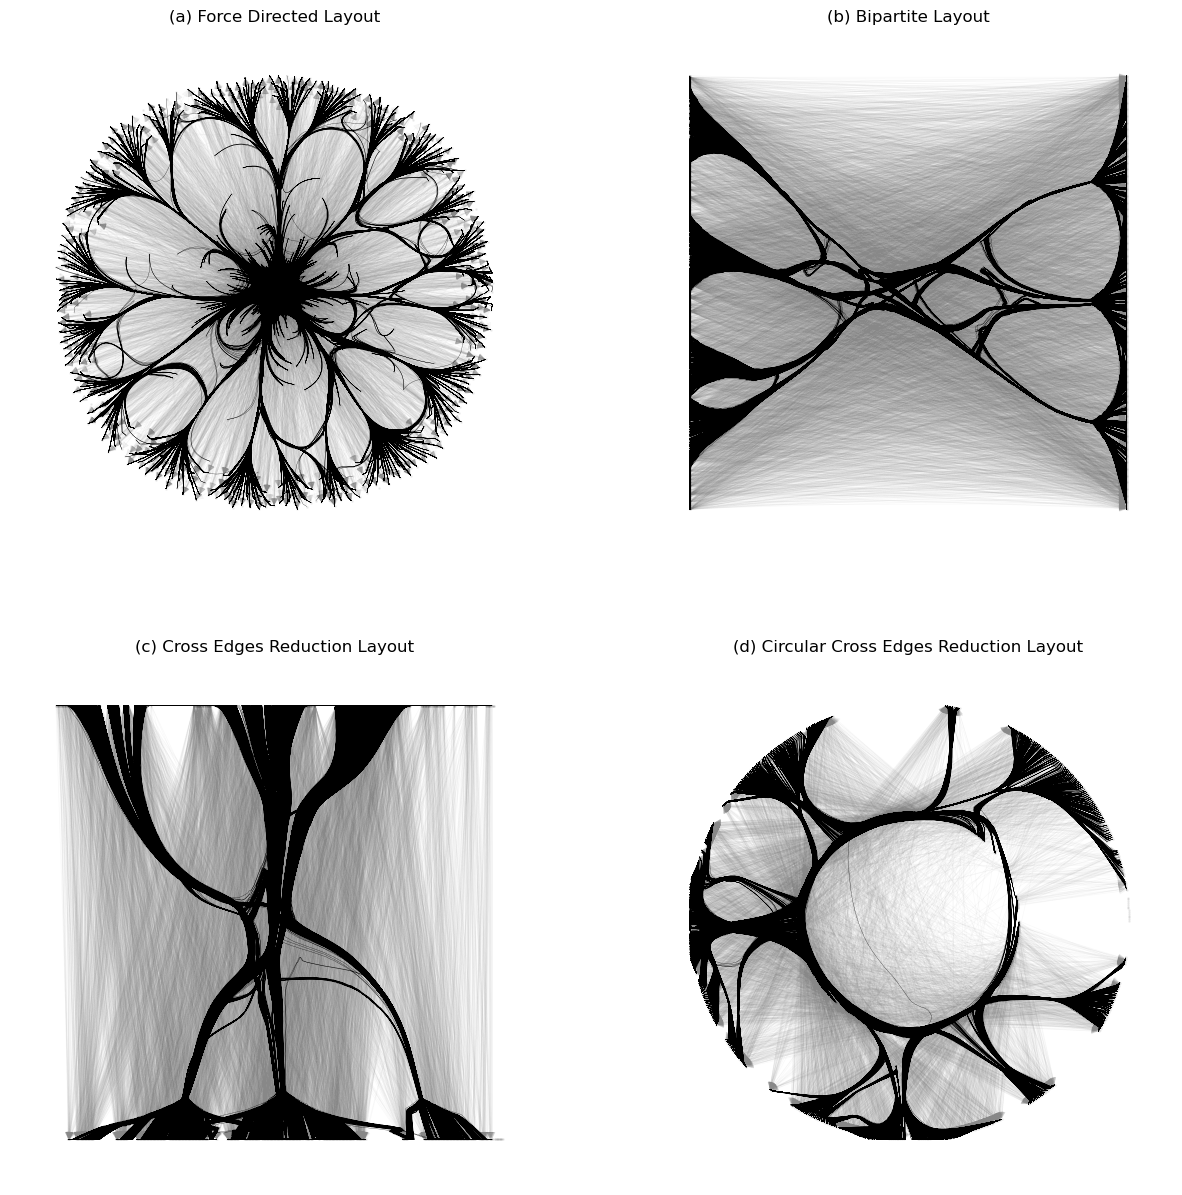

In [190]:

fig, ax = plt.subplots(2,2,figsize=(15,15))
nx.draw(g_instance, pos=pos_force, ax=ax[0,0], 
        node_size=1, node_color='black',
        edge_color='#888888', width=0.5, alpha = 0.05, )
ax[0,0].plot(bundle_curves_force.x, bundle_curves_force.y, '#000000', zorder=1, linewidth=0.2, )

nx.draw(g_instance, pos=pos_bipartite, ax=ax[0,1], 
        node_size=1, node_color='black', 
        edge_color='#888888', width=0.5, alpha = 0.05,  )
ax[0,1].plot(bundle_curves_bipartite.x, bundle_curves_bipartite.y, '#000000', zorder=1, linewidth=0.2, )

nx.draw(g_instance, pos=pos_cer, ax = ax[1,0], 
        node_size=1, node_color='black', 
        edge_color='#888888', width=0.5, alpha = 0.05, )
ax[1,0].plot(bundle_curves_cer.x, bundle_curves_cer.y, '#000000', zorder=1, linewidth=0.2, )

nx.draw(g_instance, pos=pos_cer_circ, ax=ax[1,1],
        node_size=1, node_color = 'black', 
        edge_color='#888888', width=0.5, alpha = 0.05)
ax[1,1].plot(bundle_curves_cer_circ.x, bundle_curves_cer_circ.y, '#000000', zorder=1, linewidth=0.2, )

ax[0,0].set_title("(a) Force Directed Layout")
ax[0,0].set_axis_off()
ax[0,1].set_title("(b) Bipartite Layout")
ax[0,1].set_axis_off()
ax[1,0].set_title("(c) Cross Edges Reduction Layout")
ax[1,0].set_axis_off()
ax[1,1].set_title("(d) Circular Cross Edges Reduction Layout")
ax[1,1].set_axis_off()
plt.show()


In [171]:
#depending on the radial color
cmap = plt.cm.get_cmap('hsv')  

def estimate_color(x,y, bundle_curves=None, type=0):
    if type == 0 : return np.arctan2(y,x) / (2 * np.pi) + 0.5
    elif type == 1 : 
        xmin, xmax = bundle_curves.x.min(), bundle_curves.x.max()
        return (x - xmin) / (xmax - xmin)
    elif type == 2 :
        ymin, ymax = bundle_curves.y.min(), bundle_curves.y.max()
        return (y - ymin) / (ymax - ymin)
    
def add_color_to_edges(bundle_curves, type) :
    splits = np.isnan(bundle_curves.to_numpy())[:,0].nonzero()[0]
    colors = []
    a,b = 0.4,0.4

    pos_infl = bundle_curves.iloc[0].to_numpy()
    c = estimate_color(pos_infl[0], pos_infl[1], bundle_curves, type)
    colors += [cmap(c)] * (splits[0] + 1)
    
    for i, s in enumerate(splits[:-1]): 
        pos_infl = bundle_curves.iloc[s+1].to_numpy()
        c = estimate_color(pos_infl[0], pos_infl[1], bundle_curves, type)
        c = cmap(c)
        c = (a * c[0] + b, a * c[1] + b, a * c[2] + b, c[3])
        colors += [c] * (splits[i+1] - s)
    return colors


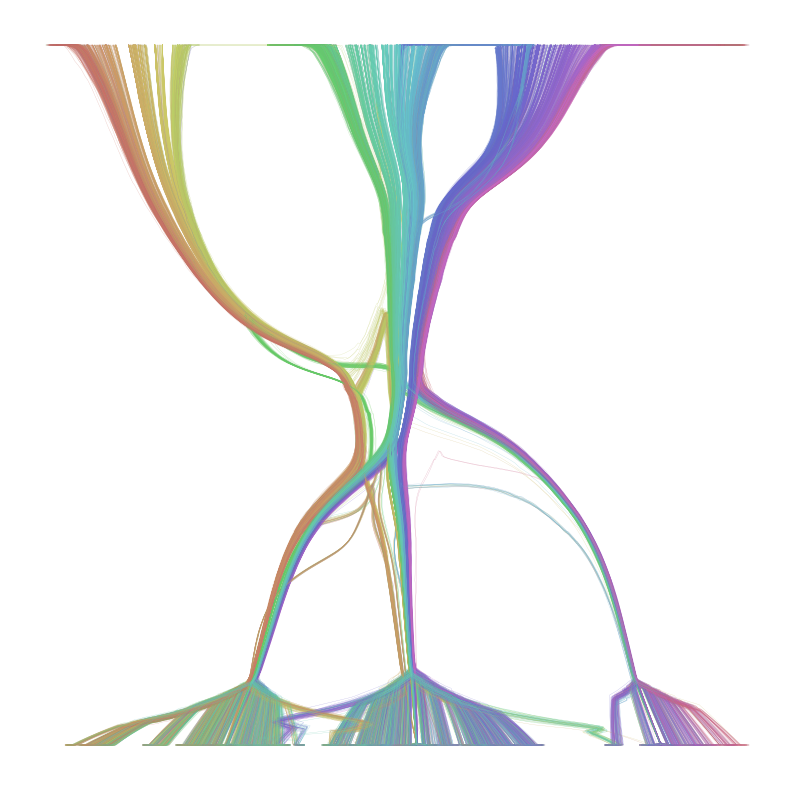

In [173]:
def plot_bundle_colors(bundle_curves, type):
    """ 0 = circular, 1 = horizontal, 2 = vertical """
    splits = np.isnan(bundle_curves.to_numpy())[:,0].nonzero()[0]
    colors = add_color_to_edges(bundle_curves, type)
    # colors = np.array(colors)[:, :3]

    fig, ax = plt.subplots(figsize=(5,5))
    for i in range(len(splits)) : 
        a,b = splits[i], splits[i+1] if i < len(splits) - 1 else len(bundle_curves)
        ax.plot(bundle_curves.iloc[a:b].x, bundle_curves.iloc[a:b].y, color=colors[a], linewidth=0.2, alpha = 0.5)
    ax.set_axis_off()
    plt.show()

# plot_bundle_colors(bundle_curves_cer_circ)
plot_bundle_colors(bundle_curves_cer, type=1)


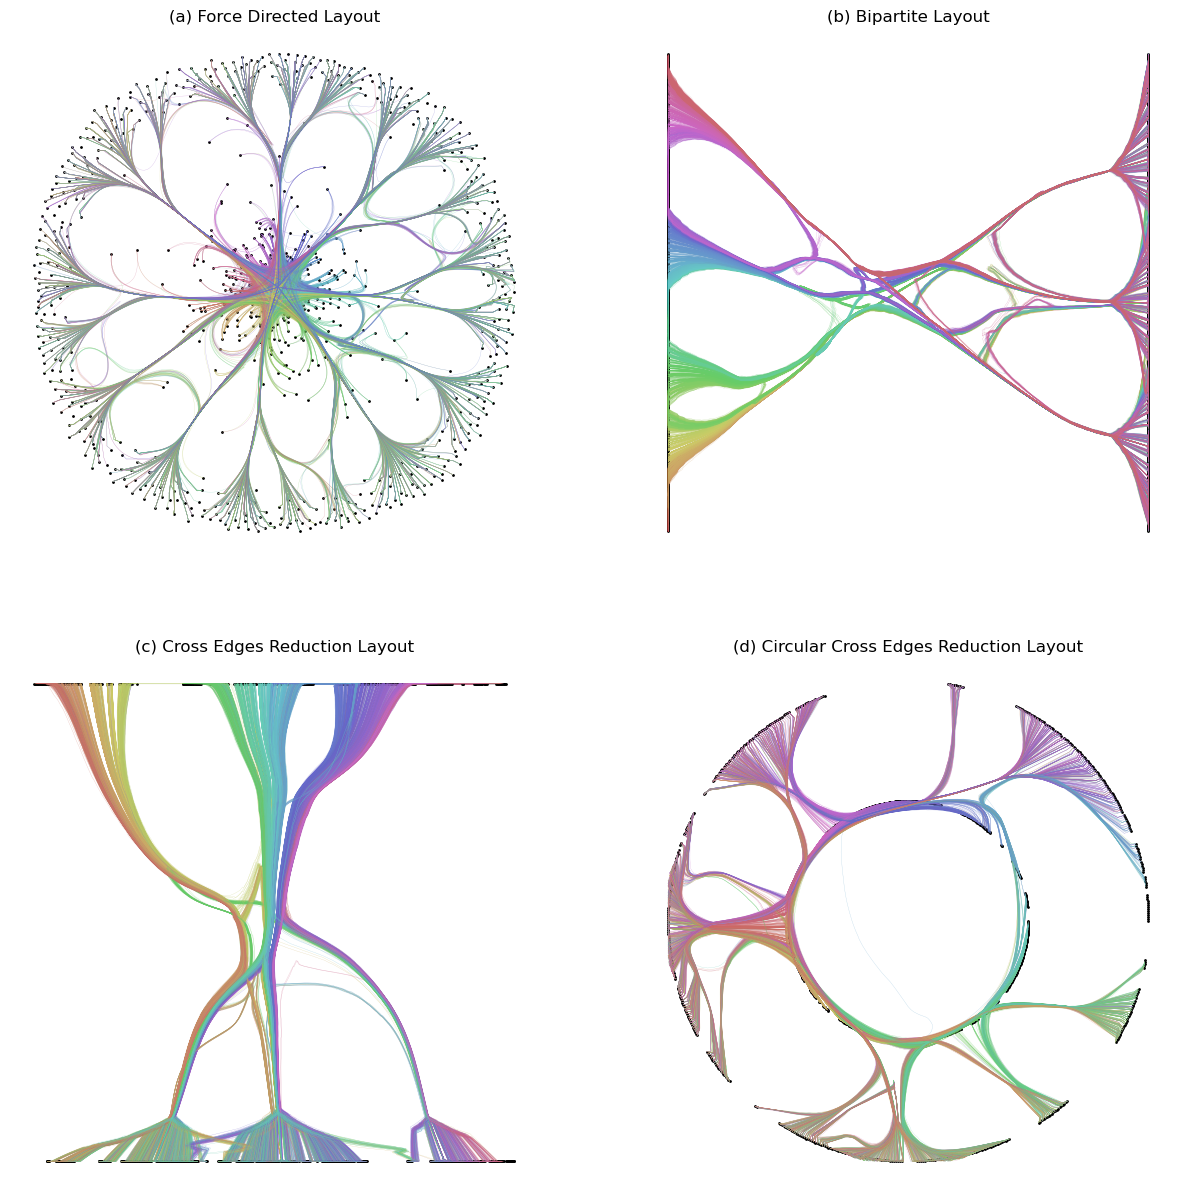

In [189]:
""" 0 = circular, 1 = horizontal, 2 = vertical """

fig, ax = plt.subplots(2,2,figsize=(15,15))

splits = np.isnan(bundle_curves_force.to_numpy())[:,0].nonzero()[0]
colors = add_color_to_edges(bundle_curves_force, type=0)
nx.draw_networkx_nodes(g_instance, pos_force, node_size=1, node_color='black', ax=ax[0,0])
for i in range(len(splits)) : 
    a,b = splits[i], splits[i+1] if i < len(splits) - 1 else len(bundle_curves_force)
    ax[0,0].plot(bundle_curves_force.iloc[a:b].x, bundle_curves_force.iloc[a:b].y, color=colors[a], linewidth=0.2, alpha = 0.5)

splits = np.isnan(bundle_curves_bipartite.to_numpy())[:,0].nonzero()[0]
colors = add_color_to_edges(bundle_curves_bipartite, type=2)
nx.draw_networkx_nodes(g_instance, pos_bipartite, node_size=1, node_color='black', ax=ax[0,1])
for i in range(len(splits)) : 
    a,b = splits[i], splits[i+1] if i < len(splits) - 1 else len(bundle_curves_bipartite)
    ax[0,1].plot(bundle_curves_bipartite.iloc[a:b].x, bundle_curves_bipartite.iloc[a:b].y, color=colors[a], linewidth=0.2, alpha = 0.5)

splits = np.isnan(bundle_curves_cer.to_numpy())[:,0].nonzero()[0]
colors = add_color_to_edges(bundle_curves_cer, type=1)
nx.draw_networkx_nodes(g_instance, pos_cer, node_size=1, node_color='black', ax=ax[1,0])
for i in range(len(splits)) : 
    a,b = splits[i], splits[i+1] if i < len(splits) - 1 else len(bundle_curves_cer)
    ax[1,0].plot(bundle_curves_cer.iloc[a:b].x, bundle_curves_cer.iloc[a:b].y, color=colors[a], linewidth=0.2, alpha = 0.5)

splits = np.isnan(bundle_curves_cer_circ.to_numpy())[:,0].nonzero()[0]
colors = add_color_to_edges(bundle_curves_cer_circ, type=0)
nx.draw_networkx_nodes(g_instance, pos_cer_circ, node_size=1, node_color='black', ax=ax[1,1])
for i in range(len(splits)) : 
    a,b = splits[i], splits[i+1] if i < len(splits) - 1 else len(bundle_curves_cer_circ)
    ax[1,1].plot(bundle_curves_cer_circ.iloc[a:b].x, bundle_curves_cer_circ.iloc[a:b].y, color=colors[a], linewidth=0.2, alpha = 0.5)

ax[0,0].set_title("(a) Force Directed Layout")
ax[0,0].set_axis_off()
ax[0,1].set_title("(b) Bipartite Layout")
ax[0,1].set_axis_off()
ax[1,0].set_title("(c) Cross Edges Reduction Layout")
ax[1,0].set_axis_off()
ax[1,1].set_title("(d) Circular Cross Edges Reduction Layout")
ax[1,1].set_axis_off()
plt.show()

In [191]:
import torch
def set_func(S, P):
    s = torch.zeros(P.shape[0])
    s[S] = 1
    return float(torch.sum(1 - torch.prod(1 - (s*P.T).T, axis = 0)))
def marginal_vec(S, P):
    s = torch.zeros(P.shape[0])
    s[S] = torch.ones(len(S))
    sc = torch.ones_like(s) - s
    return sc * torch.mv(P, torch.prod(1 - (s*P.T).T, axis = 0))
def greedy2(K, P):
    P = torch.from_numpy(P)
    S = []
    for i in range(K):
        g = marginal_vec(S, P)
        s = int(torch.argmax(g))
        if s not in S: 
            S += [s]
    return S
    
dir = 'weibo/'
model_df = torch.load(dir + 'model_df.pt', map_location=torch.device('cpu'))
model_2s = torch.load(dir + 'model_2s.pt', map_location=torch.device('cpu'))
Ydf = model_df(torch.from_numpy(X).float()).view_as(torch.from_numpy(Y)).detach()
Y2s = model_2s(torch.from_numpy(X).float()).view_as(torch.from_numpy(Y)).detach()

seeds_20 = greedy2(20, Y)
df_seeds = greedy2(20, np.array(Ydf))
twos_seeds = greedy2(20, np.array(Y2s))


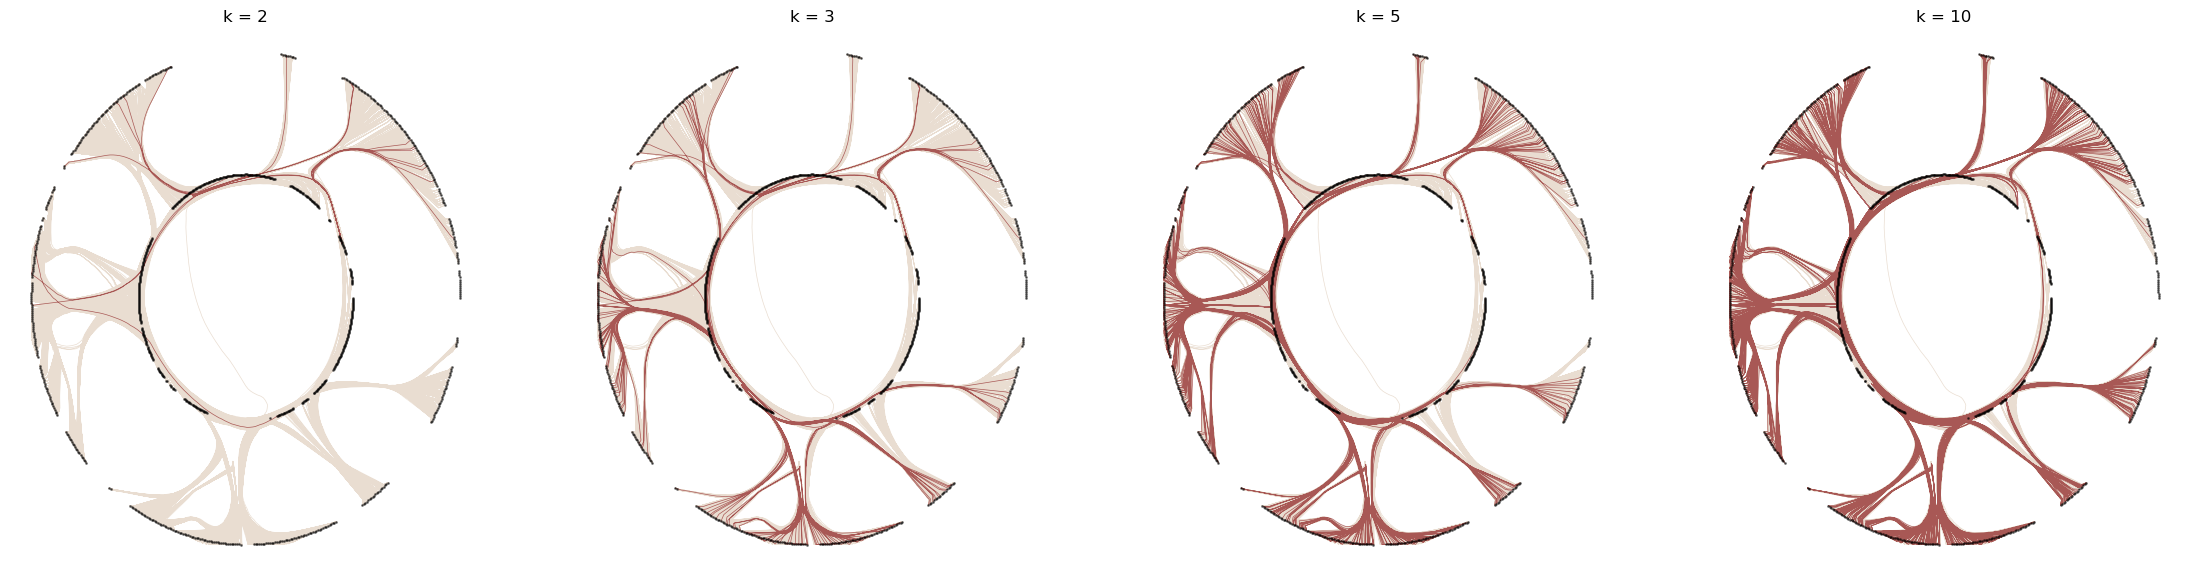

In [214]:
def f_isGreedy(bundle_curves, seeds):
    splits = np.isnan(bundle_curves.to_numpy())[:,0].nonzero()[0]
    splits_greedy = []
    for i, edge in enumerate(g_instance.edges()) :
        if edge[0] in seeds : 
            splits_greedy.append(i)
    is_greedy = []
    for i in range(len(splits_greedy)):
        is_greedy += list(range(splits[splits_greedy[i]], splits[splits_greedy[i]+1]))
    return is_greedy
    
def print_coverage(bundle_curves, pos, seeds, steps, offset = 0.05) : 

    fig, ax = plt.subplots(1,len(steps),figsize=(7 * len(steps),7))
    
    for i, step in enumerate(steps) :  
        is_greedy = f_isGreedy(bundle_curves, seeds[:step])
        bcGreedy = bundle_curves[bundle_curves.index.isin(is_greedy)]
        bcOther = bundle_curves[~bundle_curves.index.isin(is_greedy)]
        nx.draw_networkx_nodes(g_instance, pos, node_size=1, node_color='black', ax=ax[i], alpha=0.5)
        ax[i].plot(bcOther.x + offset, bcOther.y + offset, '#dbc7b3', zorder=1, linewidth=0.5, alpha = 0.6)
        ax[i].plot(bcGreedy.x, bcGreedy.y, '#7e0003', zorder=1, linewidth=0.5, alpha = 0.6)
        ax[i].set_title(f"k = {step}")
        ax[i].set_axis_off()
    plt.show()

print_coverage(bundle_curves_cer_circ, pos_cer_circ, seeds_20, [2,3,5,10,], 0.0)

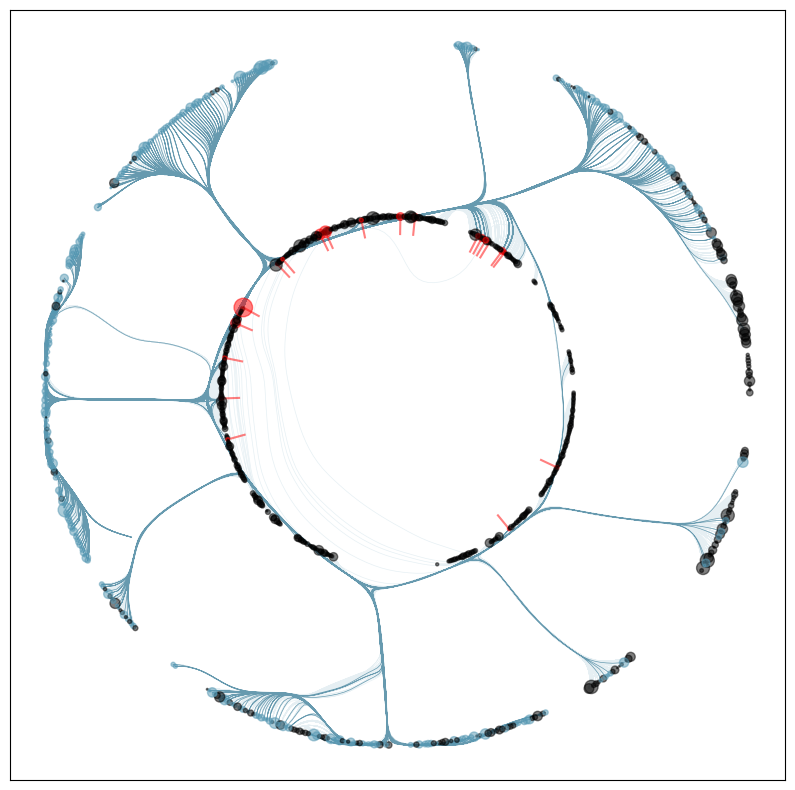

In [134]:
scale = [g_instance.nodes[n]['degree'] for n in range(1000)]
a,b,c = min(scale), sum(scale) / 1000, max(scale)
node_sizes = [10.0 * np.exp( (f - b) / (c - a) * 7 ) for f in scale]

seeds = twos_seeds[:20]

splits_greedy = []
infected = []
for i, edge in enumerate(g_instance.edges()) :
    if edge[0] in seeds : 
        splits_greedy.append(i)
        infected.append(edge[1])
is_greedy = []
for i in range(len(splits_greedy)):
    is_greedy += list(range(splits[splits_greedy[i]], splits[splits_greedy[i]+1]))
bundle_curves_greedy = bundle_curves[bundle_curves.index.isin(is_greedy)]
bundle_curves_other = bundle_curves[~bundle_curves.index.isin(is_greedy)]

fig, ax = plt.subplots(figsize=(10,10))

node_color = ['red' if n in seeds else 'black' for n in range(500)] + ['#5698b3' if n in infected else 'black' for n in range(500,1000)]

for s in seeds : 
    xs, ys = circular_bi_proj[s][0], circular_bi_proj[s][1]
    ax.add_line(plt.Line2D((0.9 * xs, xs),(0.9 * ys, ys), color="red", alpha = 0.5))

# for i in infected :
#     xs, ys = circular_bi_proj[i][0], circular_bi_proj[i][1]
#     length = (1 + scale2[i] * 0.2)
#     ax.add_line(plt.Line2D((length * xs, xs),(length * ys, ys), color="red", alpha = 0.5))

nx.draw_networkx_nodes(g_instance, pos=circular_bi_proj, alpha=0.5, ax=ax, node_color=node_color, node_size=node_sizes, cmap=cmap)
ax.plot(bundle_curves_other.x, bundle_curves_other.y, '#e0ecf1', zorder=1, linewidth=0.5, alpha = 0.8)
ax.plot(bundle_curves_greedy.x, bundle_curves_greedy.y, '#47859e', zorder=1, linewidth=0.5, alpha = 0.8)
ax.set_title("")

plt.show()





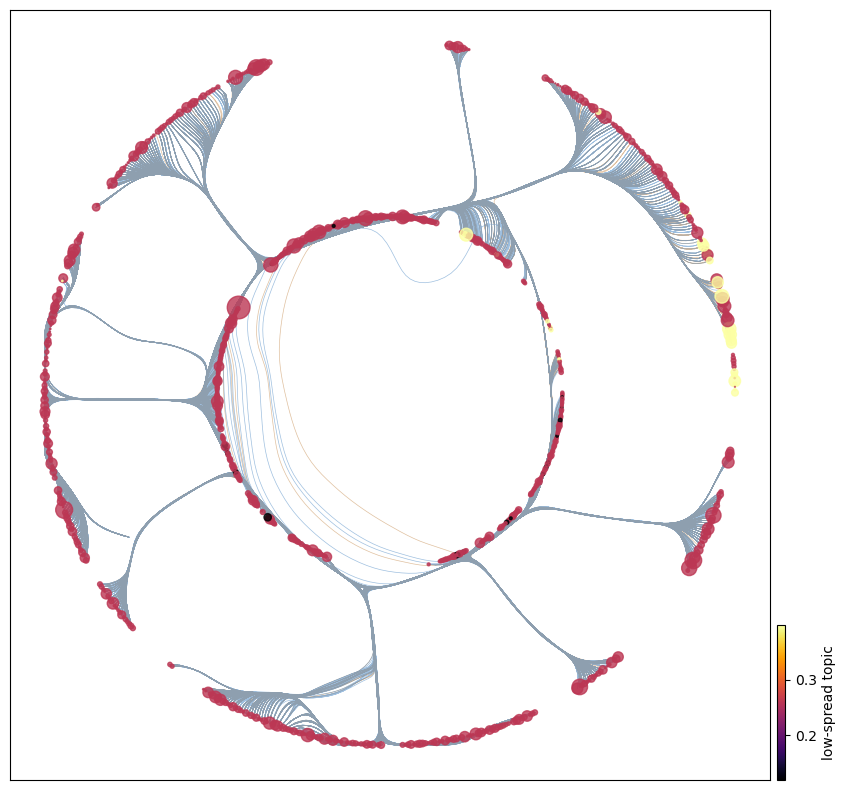

In [180]:
scale = [g_instance.nodes[n]['degree'] for n in range(1000)]
a,b,c = min(scale), sum(scale) / 1000, max(scale)
node_sizes = [10.0 * np.exp( (f - b) / (c - a) * 8 ) for f in scale]

scale2 = [g_instance.nodes[n]['low-spread topic'] for n in range(1000)] # [g_instance.nodes[0]['#cascades']] * 500
node_color = [int(10 * max(min(0.7* f, 1.0), 0)) for f in scale2]

cmap = plt.cm.get_cmap('inferno')
fig, ax = plt.subplots(figsize=(10,10))

# splitsIsSG = []
# for i, e in enumerate(g_instance.edges()) :
#     if X[e[0], e[1]-500, -1] == 1 : 
#         splitsIsSG.append(i)
# isSG = []
# for i in range(len(splitsIsSG)):
#     isSG += list(range(splits[splitsIsSG[i]], splits[splitsIsSG[i]+1]))
# bundle_curves_inSC = bundle_curves[bundle_curves.index.isin(isSG)]
# bundle_curves_outSC = bundle_curves[~bundle_curves.index.isin(isSG)]

nx.draw_networkx_nodes(g_instance, pos=circular_bi_proj, alpha=0.8, ax=ax, node_color=node_color, node_size=node_sizes, cmap=cmap)
ax.plot(bundle_curves.x, bundle_curves.y, '#c0813f', zorder=1, linewidth=0.5, alpha = 0.5)
# ax.plot(bundle_curves_outSC.x, bundle_curves_outSC.y, '#3f80c0', zorder=1, linewidth=0.5, alpha = 0.5)
ax.set_title("")

sm = plt.cm.ScalarMappable(cmap = cmap, norm = plt.Normalize(vmin = min(scale2), vmax = max(scale2)))
sm._A = []
plt.colorbar(sm, orientation="vertical",fraction=0.01,anchor=(1.0,0.0), pad=0.01, label = 'low-spread topic')

plt.show()





In [1]:
# show force directed layout 
# apply_bundling_to_nx(g_instance, pos = nx.spring_layout(g_instance, k=0.001, iterations=50), bundling_args={'initial_bandwidth': 0.05, 'decay': 0.9, 'iterations': 5, 'tension': 1.7, 'batch_size': 20000, 'advect_iterations': 50})
apply_bundling_to_nx(g_instance, \
    pos = nx.spring_layout(g_instance, k=0.001, iterations=50), \
    bundling_args={'initial_bandwidth': 0.1, 
                    'decay': 1.0, 
                    'iterations': 20, 
                    'tension': 1.9, 
                    'batch_size': 1000, 
                    'advect_iterations': 10})


NameError: name 'apply_bundling_to_nx' is not defined

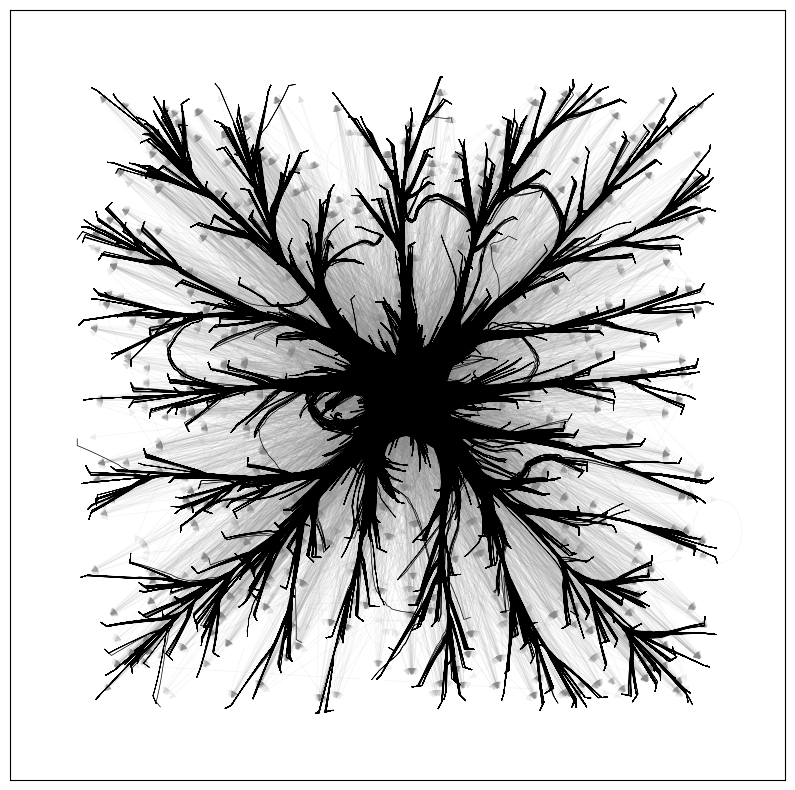

In [23]:
pos = nx.spring_layout(g_instance, k=0.001, iterations=50)
params = {'initial_bandwidth': 0.05, 'decay': 0.9, 'iterations': 10, 'tension': 1.75, 'batch_size': 20000, 'advect_iterations': 100}

bundle_curves_force = get_bundle_curves(g_instance, pos, params=params)
splits = np.isnan(bundle_curves_force.to_numpy())[:,0].nonzero()[0]

# scale = [g_instance.nodes[n]['degree'] for n in range(1000)]
# a,b,c = min(scale), sum(scale) / 1000, max(scale)
# node_sizes = [10.0 * np.exp( (f - b) / (c - a) * 8 ) for f in scale]

# # scale2 = [g_instance.nodes[n]['low-spread topic'] for n in range(1000)] # [g_instance.nodes[0]['#cascades']] * 500
# # node_color = [int(10 * max(min(0.7* f, 1.0), 0)) for f in scale2]

# # cmap = plt.cm.get_cmap('inferno')
# fig, ax = plt.subplots(figsize=(10,10))

# nx.draw_networkx_nodes(g_instance, pos=pos, alpha=0.8, ax=ax, node_size=node_sizes, )
# ax.plot(bundle_curves_force.x, bundle_curves_force.y, '#c0813f', zorder=1, linewidth=0.5, alpha = 0.5)
# ax.set_title("")
# plt.show()

fig, ax = plt.subplots(figsize=(15,15))
nx.draw_networkx_edges(g_instance, pos=pos, alpha=0.1, ax=ax, edge_color='#888888', width=0.5)
ax.plot(bundle_curves_force.x, bundle_curves_force.y, '#000000', zorder=1, linewidth=0.3)
ax.set_title("")
plt.show()

for label

In [ ]:
# import label and edge

# label_dense = pd.read_pickle("weibo/labels_dense.pkl")
# label_sparse = pd.read_pickle("weibo/labels_sparse.pkl")

# edge_dense = pd.read_pickle("./weibo/edges_dense.pkl")
# edge_sparse = pd.read_pickle("./weibo/edges_sparse.pkl")

# def export_graph(df_edge, title):
#     g = nx.DiGraph()
#     if df_edge.shape[1] == 2:
#         g.add_edges_from(df_edge[['u','v']].astype(str).values)
#     else:
#         g.add_weighted_edges_from(df_edge[['u','v','JI']].values)
#     nx.write_gml(g,title)

# export_graph(label_dense,'results/graph_viz/label_dense_150.gml')
# export_graph(label_sparse,'results/graph_viz/label_sparse.gml')
# export_graph(edge_dense,'results/graph_viz/edge_dense.gml')
# export_graph(edge_sparse,'results/graph_viz/edge_sparse.gml')

def extract_from_df(df, name_df = "label") : 
    """
    -   input : df with columns |u|v|JI| if (name_df == "label") or |u|v| if (name_df == "edges")
    -   output : nodes df and edges df compatible with datashader"""

    nodes_list = df.groupby('u').count().index.union(df.groupby('v').count().index).tolist()
    influencers = df.groupby('u').count().index.tolist()
    targets = df.groupby('v').count().index.tolist()
    def type(u) : 
        if u in influencers : 
            if u in targets : return 'b'
            else : return 'i'
        else : return 't' 
    
    nodes = pd.DataFrame({'name' : nodes_list, 'type' : [type(u) for u in nodes_list]})
    nodes.index = nodes.name
    nodes.type = nodes.type.astype('category')
    
    if name_df == "label" : edges = df[['u', 'v', 'JI']].rename(columns={'u' : 'source', 'v' : 'target', 'JI' : 'weight'})
    else : edges = df[['u', 'v']].rename(columns={'u' : 'source', 'v' : 'target'})

    return nodes, edges 
    
# nodes, edges = extract_from_df(label_sparse, name_df = "edge")
# nodes.groupby('type').count()
cvsopts = dict(plot_height=500, plot_width=500)

def graphplot(nodes, edges, name="", cat=None, bundling = True):
    
    # nodes = forceatlas2_layout(nodes, edges, iterations=5, linlog=True, k=1/(len(nodes))**5)
    nodes = circular_layout(nodes, edges)
    
    canvas = ds.Canvas(x_range= (nodes.x.min(), nodes.x.max()), y_range=(nodes.y.min(), nodes.y.max()), **cvsopts)
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    nodes_img = tf.shade(agg, cmap='Pastel1')
    
    edges = hammer_bundle(nodes, edges) if bundling else connect_edges(nodes, edges)
    edges_img = tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    return tf.stack(edges_img, nodes_img, how="over", name=name)

# tf.Images(graphplot(nodes, edges, "Bundled sparse labels", cat='type', bundling=True))